In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy import stats

In [2]:
FILE_NAME = "../../data/radio_logs2019.csv"

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("darkgrid")

In [3]:
print("Reading data...")
data = pd.read_csv(FILE_NAME)
print(f"Data shape: {data.shape[0]} lines, {data.shape[1]} columns")

Reading data...
Data shape: 5529150 lines, 3 columns


In [4]:
data

,radio,sng_id,ts
0,Jazz Radio,14476372,2020-04-01 12:39:44.000
1,RTL2,9997018,2020-01-08 08:48:26.000
2,Ouï FM,9997018,2019-11-14 01:34:49.000
3,Contact FM,9997018,2018-12-21 13:00:24.000
4,Contact FM,9997018,2019-02-05 03:43:37.000
...,...,...,...
5529145,Contact FM,810557802,2020-03-20 01:00:00.000
5529146,Contact FM,810557802,2020-03-01 13:19:36.000
5529147,Champagne FM,810557802,2020-02-15 06:44:55.000
5529148,Champagne FM,810557802,2020-03-24 14:00:52.000


# Diversity

In [5]:
# Calculate S/P for each radio station
radio_groups = data.groupby(["radio", "sng_id"]).size()
ratios = radio_groups.groupby(["radio"]).size().divide(radio_groups.sum(level="radio")).to_frame().reset_index()
ratios.columns = ["radio", "S/P"]
ratios

,radio,S/P
0,ABC Lounge Jazz,0.015884
1,Alouette,0.024638
2,Beur FM,0.053563
3,Champagne FM,0.009632
4,Chante France,0.007186
5,Chí©rie FM,0.024188
6,Contact FM,0.017108
7,Djam Radio,0.044329
8,FG,0.050314
9,Fip,0.333282


In [6]:
ratios.to_csv("../../data/radio_diversity.csv", index=False)

In [7]:
ratios = pd.read_csv("../../data/radio_diversity.csv")

In [8]:
# Fetching user ratios
sp_users = pd.read_csv("../../data/sp_ratios_full.csv")
sp_users["quantile"] = pd.qcut(sp_users["ratio"], 4, duplicates="drop")
sp_users = sp_users.groupby("quantile").mean()["ratio"].to_frame().reset_index()
sp_users["quantile"] = [f"Users (Q{i})" for i in range(1, 5)]
sp_users["type"] = "user"
sp_users

# Adding users to radio ratios -- with separation
ratios["type"] = "radio"
ratios = pd.concat([ratios, sp_users.rename(columns={"quantile": "radio", "ratio": "S/P"})])
ratios

,radio,S/P,type
0,ABC Lounge Jazz,0.015884,radio
1,Alouette,0.024638,radio
2,Beur FM,0.053563,radio
3,Champagne FM,0.009632,radio
4,Chante France,0.007186,radio
5,Chí©rie FM,0.024188,radio
6,Contact FM,0.017108,radio
7,Djam Radio,0.044329,radio
8,FG,0.050314,radio
9,Fip,0.333282,radio


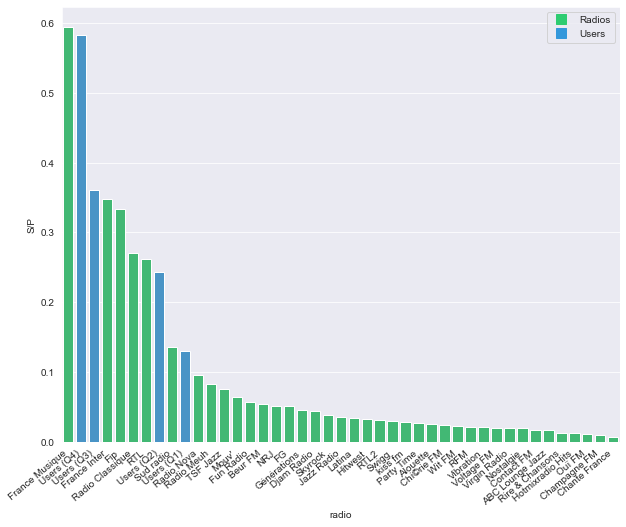

In [9]:
# Sorting for visual effect
ratios.sort_values("S/P", ascending=False, inplace=True)
clrs = ["#2ecc71" if x == "radio" else "#3498db" for x in ratios["type"]]

f, ax = plt.subplots(figsize=(10, 8))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# Plotting in two separate 
bars = sns.barplot(x="radio", y="S/P", data=ratios, palette=clrs)

# Custom legends are a pain
radios_line = mlines.Line2D([], [], color="#2ecc71", marker="s", linestyle='None',
                          markersize=10, label="Radios")
userss_line = mlines.Line2D([], [], color="#3498db", marker="s", linestyle='None',
                          markersize=10, label="Users")
ax.legend(handles=[radios_line, userss_line])
# ax.legend(["users", "radios"], loc='upper right', frameon=False)

plt.savefig("../../results/radio/radios_sp.pdf")

In [29]:
# Reproduction de la figure 1b) -- S/P en fonction de P
radio_logp = np.log(data.groupby("radio").size()).to_frame().reset_index().rename(columns={0: "logp"})
radio_logp = ratios.merge(radio_logp, on="radio")

radio_logp["quantile"] = pd.cut(radio_logp["logp"], np.arange(9.5, 13.5, 1))

plays_means = radio_logp.groupby(["quantile"]).mean()["S/P"].to_frame().reset_index().drop("quantile", axis=1)
plays_means["logp"] = np.arange(10, 13, 1)
plays_means

,S/P,logp
0,0.198582,10
1,0.192082,11
2,0.044283,12


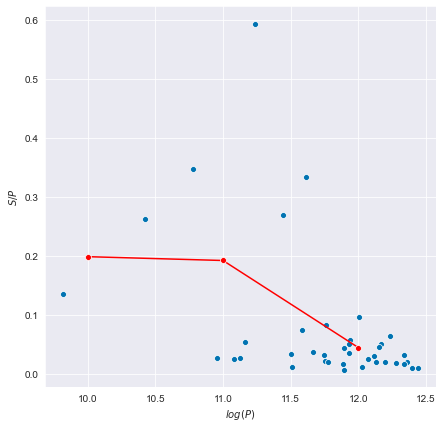

In [31]:
f, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x="logp", y="S/P", data=radio_logp)
sns.lineplot(x="logp", y="S/P", data=plays_means, color="r", marker= "o")
ax.set(ylabel="$S/P$", xlabel="$log(P)$")
plt.savefig("../../results/radio/sp_logp_bins_radio.pdf")

# Mainstream

In [4]:
import nbimporter
import mainstream_tests

Importing Jupyter notebook from mainstream_tests.ipynb


In [5]:
data

,radio,sng_id,ts
0,Jazz Radio,14476372,2020-04-01 12:39:44.000
1,RTL2,9997018,2020-01-08 08:48:26.000
2,Ouï FM,9997018,2019-11-14 01:34:49.000
3,Contact FM,9997018,2018-12-21 13:00:24.000
4,Contact FM,9997018,2019-02-05 03:43:37.000
...,...,...,...
999995,Nostalgie,115140514,2020-03-07 23:36:48.000
999996,Mouv',1184116,2018-06-16 20:42:57.000
999997,Jazz Radio,62811724,2019-12-18 13:58:36.000
999998,ABC Lounge Jazz,854786342,2019-02-05 05:57:17.000


In [6]:
# Binning -- see mainstream_tests.ipynb
songs = pd.read_csv("../../data/artist_songs.csv")
data = data.merge(songs, on="sng_id")
data

,radio,sng_id,ts,art_id
0,RTL2,9997018,2020-01-08 08:48:26.000,412
1,Ouï FM,9997018,2019-11-14 01:34:49.000,412
2,Contact FM,9997018,2018-12-21 13:00:24.000,412
3,Contact FM,9997018,2019-02-05 03:43:37.000,412
4,Champagne FM,9997018,2019-04-27 16:41:40.000,412
...,...,...,...,...
180455,Fip,126974013,2018-08-13 10:23:53.000,1536
180456,RTL,3845070,2019-08-17 22:07:10.000,1420
180457,FG,107352300,2018-04-20 23:19:46.000,145562
180458,Fun Radio,81836818,2019-09-23 17:41:14.000,864274


In [6]:
# Identify songs with unknown artists
# data[data["art_id"].isna()]["sng_id"].drop_duplicates().to_csv("../../data/songs_no_artists.csv", index=False)

In [20]:
data = mainstream_tests.bin_artists(data, bin_amnt=4, separate_reco=False)

Counting artist occurences...
Binning artists...
Number of artists per bin: 
bin
(-16.615, 4404.75]     1190
(4404.75, 8808.5]       201
(8808.5, 13212.25]       91
(13212.25, 17616.0]      38
dtype: int64
Artists binned into 4 categories.


In [31]:
radio_bins = data[(data["radio"] == "RTL") | (data["radio"] == "Contact FM")].groupby(["radio", "bin_nb"]).size().to_frame().reset_index()
radio_bins.columns = ["radio", "bin_nb", "amount"]
radio_bins

,radio,bin_nb,amount
0,Contact FM,1,99
1,Contact FM,2,159
2,Contact FM,3,167
3,Contact FM,4,215
4,RTL,1,48
5,RTL,2,31
6,RTL,3,49
7,RTL,4,31


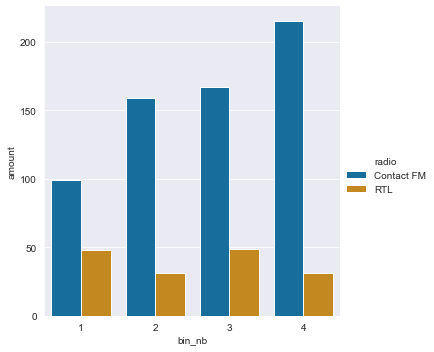

In [32]:
sns.catplot(x="bin_nb", y="amount", data=radio_bins, kind="bar", hue="radio")